# 02 - Segment Analysis

Deep dive into segment properties and data export.

## What You'll Learn
- Understand all segment attributes
- Export segments to pandas DataFrame
- Analyze segment statistics
- Interpret why segments were created

## Setup

In [1]:
import yfinance as yf

from trend_classifier import Segmenter

# Download data
df = yf.download("AAPL", start="2018-09-15", end="2022-09-05", interval="1d", progress=False)

# Create and calculate segments
seg = Segmenter(df=df, column="Close", n=20)
seg.calculate_segments()

print(f"Analyzing {len(seg.segments)} segments")

Analyzing 49 segments


## Segment Attributes

Each `Segment` object contains rich information about the detected trend:

| Attribute | Description |
|-----------|-------------|
| `start` | Start index in the time series |
| `stop` | End index in the time series |
| `slope` | Overall slope of the linear trend |
| `offset` | Y-intercept of the linear trend |
| `std` | Standard deviation after detrending (volatility) |
| `span` | Normalized range of values |
| `slopes` | List of slopes from individual windows |
| `offsets` | List of offsets from individual windows |
| `slopes_std` | Std of slopes (trend consistency) |
| `offsets_std` | Std of offsets |
| `reason_for_new_segment` | Why this segment ended |

In [2]:
# Examine a single segment in detail
segment = seg.segments[2]

print("=== Segment Details ===")
print(f"Range: index {segment.start} to {segment.stop} ({segment.stop - segment.start} points)")
print(f"Slope: {segment.slope:.4f}")
print(f"Offset: {segment.offset:.2f}")
print(f"Volatility (std): {segment.std:.4f}")
print(f"Span: {segment.span:.1f}")
print(f"Trend consistency (slopes_std): {segment.slopes_std:.4f}")
print(f"Reason segment ended: '{segment.reason_for_new_segment}'")

=== Segment Details ===
Range: index 76 to 81 (5 points)
Slope: 0.1050
Offset: 27.73
Volatility (std): 0.4467
Span: 30.9
Trend consistency (slopes_std): 0.0000
Reason segment ended: 'slope'


In [3]:
# The full representation
print("\nFull repr:")
print(repr(segment))


Full repr:
Segment(start=76, stop=81, slope=0.10499692644392077, offset=27.7340259370347, std=0.44673911715410836, span=30.945143102918966, reason_for_new_segment=slope, slopes=[0.2653123439702775], offsets=[14.540656963147605], slopes_std=0.0, offsets_std=0.0)


## Export to DataFrame

The `to_dataframe()` method converts all segments to a pandas DataFrame for easy analysis.

In [4]:
# Convert segments to DataFrame
df_segments = seg.segments.to_dataframe()
df_segments

,start,stop,slope,offset,slopes_std,offsets_std,std,span,reason_for_new_segment,slopes,offsets
0,0,9,0.197502,51.373652,0.000000,0.000000,0.313283,17.926021,slope,[-0.1002435239634121],[54.312332704013464]
1,10,75,-0.315274,58.936524,0.128520,4.743325,1.432513,152.753008,slope,"[-0.15026299899682063, -0.15786464375660753, -...","[55.39250845944972, 55.46701279546978, 62.3780..."
2,76,81,0.104997,27.734026,0.000000,0.000000,0.446739,30.945143,slope,[0.2653123439702775],[14.540656963147605]
3,82,153,0.180014,21.923825,0.065423,7.017021,0.784706,94.854749,slope,"[0.28343645827214536, 0.1573499894679941, 0.05...","[12.548412297184312, 24.649738174094253, 35.11..."
4,154,171,-0.418104,114.731870,0.000000,0.000000,0.958458,83.338636,slope,[0.20273512359848547],[8.268741292164817]
5,172,177,-0.252725,86.487991,0.000000,0.000000,0.220665,16.343903,offset,[0.3256940827333848],[-14.319836067257278]
6,178,183,0.759340,-92.129464,0.000000,0.000000,0.143346,9.394813,offset,[0.16418316489771786],[16.008887923391246]
7,184,243,0.052121,37.712443,0.069056,14.926482,0.921518,99.864373,offset,"[0.10541228674408207, 0.09235581132702286, 0.0...","[27.264427543582734, 29.83007757717522, 29.861..."
8,244,255,0.094036,29.266863,0.000000,0.000000,0.696379,41.776869,slope,[0.20368984767368656],[0.727319608416445]
9,256,261,0.290731,-21.991700,0.000000,0.000000,0.356201,20.937572,offset,[0.29768106274138795],[-24.30454409319677]


In [5]:
# Select most useful columns
df_summary = df_segments[["start", "stop", "slope", "std", "span", "reason_for_new_segment"]].copy()
df_summary["length"] = df_summary["stop"] - df_summary["start"]
df_summary

,start,stop,slope,std,span,reason_for_new_segment,length
0,0,9,0.197502,0.313283,17.926021,slope,9
1,10,75,-0.315274,1.432513,152.753008,slope,65
2,76,81,0.104997,0.446739,30.945143,slope,5
3,82,153,0.180014,0.784706,94.854749,slope,71
4,154,171,-0.418104,0.958458,83.338636,slope,17
5,172,177,-0.252725,0.220665,16.343903,offset,5
6,178,183,0.759340,0.143346,9.394813,offset,5
7,184,243,0.052121,0.921518,99.864373,offset,59
8,244,255,0.094036,0.696379,41.776869,slope,11
9,256,261,0.290731,0.356201,20.937572,offset,5


## Statistical Analysis

In [6]:
# Descriptive statistics
print("=== Segment Statistics ===")
print(f"Number of segments: {len(df_segments)}")
print(f"Average segment length: {df_summary['length'].mean():.1f} points")
print(f"Shortest segment: {df_summary['length'].min()} points")
print(f"Longest segment: {df_summary['length'].max()} points")

=== Segment Statistics ===
Number of segments: 49
Average segment length: 19.4 points
Shortest segment: 5 points
Longest segment: 71 points


In [7]:
# Slope distribution
print("\n=== Slope Distribution ===")
print(df_segments["slope"].describe())


=== Slope Distribution ===
count    49.000000
mean      0.066328
std       0.864553
min      -2.293729
25%      -0.490511
50%       0.180014
75%       0.559880
max       2.036399
Name: slope, dtype: float64


In [8]:
# Count trends by direction
uptrends = (df_segments["slope"] > 0).sum()
downtrends = (df_segments["slope"] < 0).sum()

print(f"\nUptrends: {uptrends} ({100*uptrends/len(df_segments):.1f}%)")
print(f"Downtrends: {downtrends} ({100*downtrends/len(df_segments):.1f}%)")


Uptrends: 31 (63.3%)
Downtrends: 18 (36.7%)


## Understanding `reason_for_new_segment`

This attribute explains why the algorithm decided to end a segment:
- **"slope"**: The slope changed significantly
- **"offset"**: The offset changed significantly  
- **"slope and offset"**: Both changed

In [9]:
# Count reasons
reason_counts = df_segments["reason_for_new_segment"].value_counts()
print("Why segments ended:")
print(reason_counts)

Why segments ended:
reason_for_new_segment
slope               16
offset              16
slope and offset    16
                     1
Name: count, dtype: int64


## Volatility Analysis

The `std` attribute measures volatility after removing the linear trend.
Low std = clean trend, High std = noisy/choppy trend.

In [10]:
# Find cleanest and noisiest trends
cleanest_idx = df_segments["std"].idxmin()
noisiest_idx = df_segments["std"].idxmax()

print(f"Cleanest trend: Segment {cleanest_idx} (std={df_segments.loc[cleanest_idx, 'std']:.4f})")
print(f"Noisiest trend: Segment {noisiest_idx} (std={df_segments.loc[noisiest_idx, 'std']:.4f})")

Cleanest trend: Segment 6 (std=0.1433)
Noisiest trend: Segment 19 (std=3.9417)


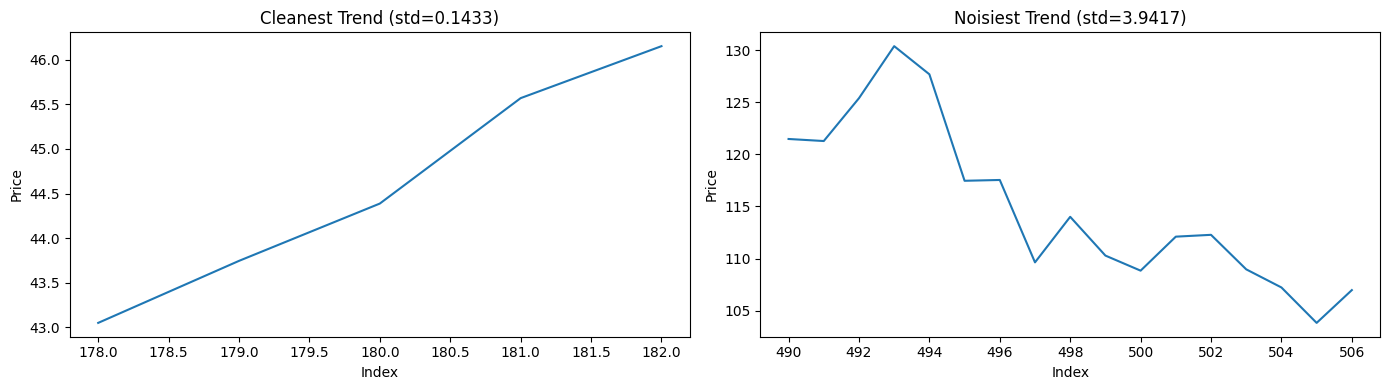

In [11]:
# Visualize cleanest vs noisiest
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, idx, title in [(axes[0], cleanest_idx, "Cleanest Trend"), 
                        (axes[1], noisiest_idx, "Noisiest Trend")]:
    s = seg.segments[idx]
    x_seg = seg.x[s.start:s.stop]
    y_seg = seg.y[s.start:s.stop]
    ax.plot(x_seg, y_seg)
    ax.set_title(f"{title} (std={s.std:.4f})")
    ax.set_xlabel("Index")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()

## Next Steps

- **03_visualization.py** - All plotting methods in detail
- **04_configuration.py** - Tune parameters to get better segments